Este notebook tem a implementação completa para pegar a base de dados, processar, fazer um treinamento e gerar o resultado.

# Carregando data frame

In [2]:
import pandas as pd
import numpy as np

df_train = pd.read_csv('input/train.csv')
df_test = pd.read_csv("input/test.csv")

# Tratando NaNs

In [3]:
df_train.fillna(-9999, inplace=True)
df_test.fillna(-9999, inplace=True)

# Tratando categóricos: LabelEncoder

In [4]:
from sklearn.preprocessing import LabelEncoder
encoded_columns = []
for column in df_test.columns:
    if df_test[column].dtype == np.object:
        train_values = list(df_train[column].values)
        test_values = list(df_test[column].values)
        encoder = LabelEncoder()
        encoder.fit(np.unique(train_values + test_values))
        df_train[column] = encoder.transform(train_values)
        df_test[column] = encoder.transform(test_values)
        encoded_columns.append(column)
encoded_columns

['v3',
 'v22',
 'v24',
 'v30',
 'v31',
 'v47',
 'v52',
 'v56',
 'v66',
 'v71',
 'v74',
 'v75',
 'v79',
 'v91',
 'v107',
 'v110',
 'v112',
 'v113',
 'v125']

# Removendo dados inúteis

In [5]:
# O 'ID' foi definido como inutil devido a analise feita no notebook de Analises
df_train.drop(['ID'], axis=1, inplace=True)
df_test.drop(['ID'], axis=1, inplace=True)

# Inicializado variáveis

In [6]:
# O target é a saida e não uma feature
features = df_train.columns.difference(['target'])

X = df_train[features].values
y = df_train['target'].values

features

Index(['v1', 'v10', 'v100', 'v101', 'v102', 'v103', 'v104', 'v105', 'v106',
       'v107',
       ...
       'v90', 'v91', 'v92', 'v93', 'v94', 'v95', 'v96', 'v97', 'v98', 'v99'],
      dtype='object', length=131)

# PCA

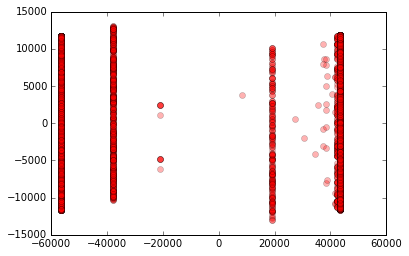

In [33]:
%matplotlib inline
import matplotlib.pyplot as plt
from sklearn import decomposition

# Roda o PCA
pca = decomposition.PCA(n_components=2)
data = pca.fit_transform(df_train)

# Plota o resultado do target 0
data0 = data[df_train[df_train['target'] == 0].index.values]
plt.plot(data0[:,0], data0[:,1], 'o', color='r', alpha=0.3)

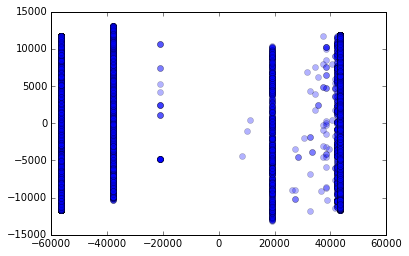

In [56]:
# Plota o resultado do target 1
data1 = data[df_train[df_train['target'] == 1].index.values]
plt.plot(data1[:,0], data1[:,1], 'o', color='b', alpha=0.3)

# Random Forest

In [7]:
from sklearn.ensemble import RandomForestClassifier
from sklearn.metrics import log_loss

classifier = RandomForestClassifier(random_state=1986, n_estimators=10, max_depth=10)
classifier.fit(X, y)

y_predicted = classifier.predict_proba(X)[:, 1]

log_loss(y, y_predicted)

0.46458167255438498

# Train vs Test

In [37]:
from sklearn.cross_validation import train_test_split

X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.33, random_state=42)

classifier = RandomForestClassifier(random_state=1986, n_estimators=10, max_depth=10)
classifier.fit(X_train, y_train)

y_predicted = classifier.predict_proba(X_test)[:, 1]

log_loss(y_test, y_predicted)

0.48989041890930712

# Cross Validation

In [59]:
from sklearn.cross_validation import cross_val_score

classifier = RandomForestClassifier(random_state=1986, n_estimators=10, max_depth=10)
scores = cross_val_score(classifier, X_full, y, scoring='log_loss')
# O resultado é um array de scores, um para cada fold. A media é para termos um score geral.
scores, np.mean(scores)

(array([-0.11214115, -0.11084534, -0.16120487]), -0.12806378656245981)

# Buscando os melhores parâmetros: Grid Search

In [8]:
from sklearn.grid_search import GridSearchCV

param_grid = {
            "criterion": ['entropy', 'gini'],
            "n_estimators": [10],
            "bootstrap": [False, True],
            "max_depth": [10],
            #"max_features": ['auto', 0.08, 0.2, 0.3],
            #"min_samples_split": [2, 5, 10],
            #"min_samples_leaf": [1, 3, 5]
}

gs_classifier = GridSearchCV(classifier, param_grid, scoring="log_loss")
gs_classifier.fit(X, y)

# Apos o fit o objeto gs_classifier tera as informacoes do busca de parametros
classifier = gs_classifier.best_estimator_ 

gs_classifier.best_params_, gs_classifier.best_score_

({'bootstrap': False,
  'criterion': 'gini',
  'max_depth': 10,
  'n_estimators': 10},
 -0.48836192571133402)

# Feature Importance

In [65]:
importances = classifier.feature_importances_
indices = np.argsort(importances)[::-1]
print("Feature ranking:")
for f in range(len(importances)):
    print("   %5s: %f%%" % (features[indices[f]], importances[indices[f]]*100))

Feature ranking:
     v50: 21.608402%
     v66: 7.017050%
     v12: 4.844809%
    v129: 4.758532%
     v79: 4.523039%
    v110: 4.022079%
     v10: 3.631632%
     v56: 3.346472%
     v31: 2.835780%
    v114: 2.733718%
    v113: 2.644339%
     v62: 2.368447%
     v47: 1.913698%
     v40: 1.860818%
     v34: 1.667600%
     v14: 1.520532%
     v21: 1.413525%
     v72: 0.889813%
     v24: 0.797208%
     v19: 0.433445%
     v68: 0.405745%
     v45: 0.375544%
     v22: 0.375040%
      v6: 0.365672%
     v80: 0.355123%
     v69: 0.339092%
    v100: 0.334040%
    v119: 0.328820%
     v57: 0.324710%
    v125: 0.324615%
     v87: 0.321756%
    v109: 0.317613%
     v97: 0.311731%
     v48: 0.301796%
    v123: 0.301007%
     v61: 0.295829%
      v2: 0.293707%
     v78: 0.288974%
    v115: 0.287923%
      v8: 0.282972%
     v29: 0.282693%
    v117: 0.281120%
     v58: 0.279155%
    v120: 0.274126%
     v86: 0.273203%
     v44: 0.272759%
     v51: 0.269606%
     v13: 0.267006%
    v124: 0.266641%
  

# Gerando resultados

In [69]:
y_pred = classifier.predict_proba(df_test[features])[:,1]
submission = pd.read_csv('input/sample_submission.csv')
submission['PredictedProb'] = y_pred
submission.to_csv('result.csv', index=False)